In [11]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt



# Desactiva todas las GPUs
tf.config.set_visible_devices([], 'GPU')

In [12]:
# Imágen 3D a tensor de imágen 4D
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, preprocess_fn=lambda x: x):
    if type(img_array) == str:
        img_array = get_img_array(img_array,(224,224))
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
        img_array = tf.identity(img_array, name="entrada_imagen")

    # We apply the preprocess function needed by the model
    img_array = preprocess_fn(img_array)
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    # lo siguiente es equivalente a: african_elephant_output = model.output[:,386], 
    # donde elefante es la clase 386 y class_channel es african_elephant_output
    # class_channel contiene el id de la clase pred_index; la 386: elefante, en nuestro ejemplo
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            # print(pred_index)
        class_channel = preds[0]#[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    # Nos devuelve todos los valores de los gradientes que le llegan a cada valor de 
    # activación de cada mapa de activación (canal) en la última capa convolucional
    # imaginemos 512 mapas de activación de 14x14: obtendremos 14x14x512 valores de gradientes.
    # Estos valores de gradientes indican la importancia de cada area de cada mapa de activacion
    # respecto (gradiente) la salida de la categoria 386 (elefante).
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    # En nuestro ejemplo, el tensor tiene un shape (?,14,14,512)
    # Con la siguiente instrucción promediamos en las dimensiones 0, 1 y 2 (sacamos un valor de cada 
    # 14x14), y nos quedamos con 512 valores promediados, que nos indican lo importante (el peso) que
    # tiene cada mapa de activación (canal) en la clasificación de la imagen de entrada como un elefante.
    # El shape de pooled_grads será (512,) en nuestro ejemplo
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0] # solo hay una imagen [0], no un batch de entrada
    
    # La siguiente instrucción es equivalente a:
    #for i in range(512):
    #    last_conv_layer_output[:,:,i] *= pooled_grads[i]
    # Lo que hacemos es una combinación lineal de los 512 mapas de activación (canales), ponderando cada uno
    # con el peso que obtuvimos promediando sus gradientes individuales.
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # Elimina dimensiones de tamaño 1 en el tensor (en este caso la primera dimensión (solo un elefante))
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [13]:
def save_and_display_gradcam(img_path, heatmap= None, cam_path="cam.jpg", alpha=0.4,model=None, last_conv_layer_name=None, pred_index=None, preprocess_fn=lambda x: x, save=True):
    if not heatmap:
        heatmap = make_gradcam_heatmap(img_path, model, last_conv_layer_name, pred_index, preprocess_fn)
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255 (para mezclarlo con los pixels de la imagen)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img  # proporción heatmap vs. imagen en el resultado
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    if save:
        # Save the superimposed image
        superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

## Modelo desde cero

In [14]:
modelo = keras.models.load_model("../models/classifier/vgg16_finetuned_11_25_11_17.keras")
# cero.summary()

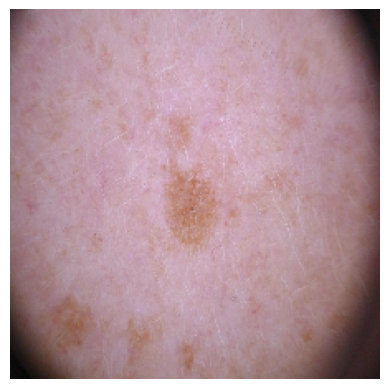

In [15]:
carpeta = "../data/processed/test/benignas/"
imagen = "ISIC_0024409.jpg"
benign_path = carpeta + imagen
plt.imshow(get_img_array(benign_path, (224,224))[0].astype(np.uint8))
plt.axis("off")
plt.show()

In [16]:
print(modelo.predict(vgg16_preprocess(get_img_array(benign_path, (224,224)))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
[[0.06539977]]


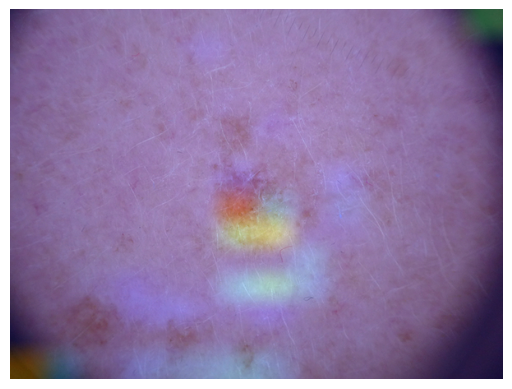

In [17]:
save_and_display_gradcam(benign_path, model=modelo, last_conv_layer_name="block5_conv3", preprocess_fn=vgg16_preprocess, save=False)

### Maligna

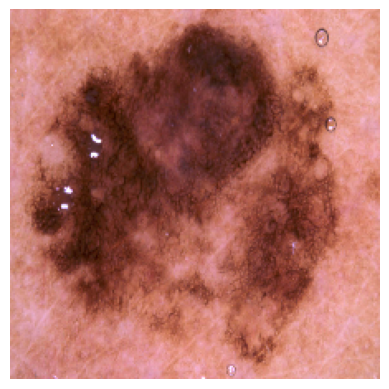

In [18]:
carpeta = "../data/processed/test/malignas/"
imagen = "ISIC_0032110.jpg"
maling_path = carpeta + imagen
plt.imshow(get_img_array(maling_path, (224,224))[0].astype(np.uint8))
plt.axis("off")
plt.show()

In [19]:
print(modelo.predict(vgg16_preprocess(get_img_array(maling_path, (224,224)))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
[[0.74255615]]


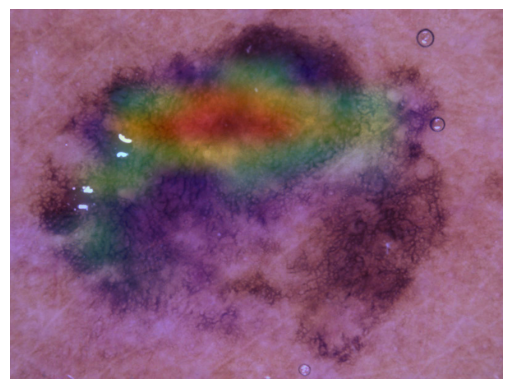

In [20]:
save_and_display_gradcam(maling_path, model=modelo, last_conv_layer_name="block5_conv3", preprocess_fn=vgg16_preprocess, save=False)